## Configurações

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('../data/input/creditcard_clean.csv')

## Pré-processamento para Machine Learning

In [3]:
features = df.columns[:-1]
target = df.columns[-1]

print(f'Features: {features}')
print(f'Target: {target}')

Features: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
Target: Class


In [4]:
y = df['Class']
X = df.drop('Class', axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
preprocessor = ColumnTransformer([
    ('num_transformer', StandardScaler(), features)
], remainder='passthrough')

In [7]:
X_train_preproc = preprocessor.fit_transform(X_train)
X_test_preproc = preprocessor.transform(X_test)

In [8]:
X_test_df = pd.DataFrame(X_test_preproc, columns=features)
X_test_df.to_csv("../data/output/X_test.csv")
y_test.to_csv("../data/output/y_test.csv")

In [9]:
X_train_preproc.shape

(226980, 30)

> Isso nos deixa com +226k amostras para treino, cada uma com 30 features

> Como já notado anteriormente, nossos dados estão desbalanceados:

In [10]:
y_train.value_counts()

Class
0    226590
1       390
Name: count, dtype: int64

Vamos treinar 3 modelos distintos para comparação:
* Normal, sem tratamento de desbalanceamento
* Com SMOTE (Synthetic Minority Oversampling Technique)
* Com ajuste de pesos

## Regressão Logística Normal

In [11]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

In [12]:
log_reg.fit(X_train_preproc, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [13]:
y_pred = log_reg.predict(X_test)

/Users/nicole.petrica/Workspace/Studies/credit-card-fraud/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [14]:
results_normal = {
    "Modelo": "Normal",
    "ROC-AUC": roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]),
    "PR-AUC": average_precision_score(y_test, log_reg.predict_proba(X_test)[:,1]),
    "Precision": classification_report(y_test, y_pred, output_dict=True)["1"]["precision"],
    "Recall": classification_report(y_test, y_pred, output_dict=True)["1"]["recall"],
    "F1": classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"],
}

/Users/nicole.petrica/Workspace/Studies/credit-card-fraud/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/nicole.petrica/Workspace/Studies/credit-card-fraud/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [16]:
cm_normal = confusion_matrix(y_test, y_pred)

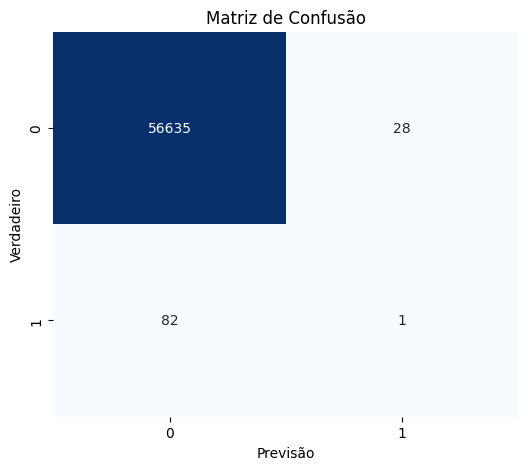

In [17]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

## Regressão Logística com SMOTE

In [18]:
sm = SMOTE(random_state=42)

In [19]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [21]:
X_train_sm_df = pd.DataFrame(X_train_sm, columns=features)
X_train_sm_df.to_csv("../data/output/X_smote.csv")
y_train_sm.to_csv("../data/output/y_smote.csv")

In [22]:
y_train_sm.value_counts()

Class
0    226590
1    226590
Name: count, dtype: int64

Text(0.5, 0, 'Class')

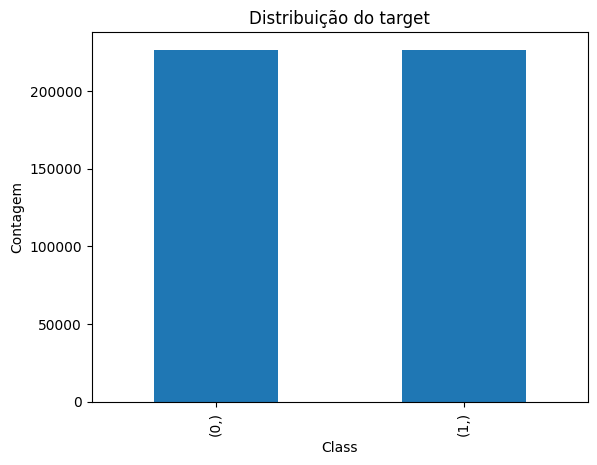

In [23]:
pd.DataFrame(y_train_sm).value_counts().plot(kind='bar')
plt.title("Distribuição do target")
plt.ylabel("Contagem")
plt.xlabel("Class")

In [24]:
log_reg_sm = LogisticRegression(max_iter=1000, random_state=42)

In [25]:
log_reg_sm.fit(X_train_sm, y_train_sm)

/Users/nicole.petrica/Workspace/Studies/credit-card-fraud/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [26]:
y_pred_sm = log_reg_sm.predict(X_test)

In [27]:
results_smote = {
    "Modelo": "SMOTE",
    "ROC-AUC": roc_auc_score(y_test, log_reg_sm.predict_proba(X_test)[:,1]),
    "PR-AUC": average_precision_score(y_test, log_reg_sm.predict_proba(X_test)[:,1]),
    "Precision": classification_report(y_test, y_pred_sm, output_dict=True)["1"]["precision"],
    "Recall": classification_report(y_test, y_pred_sm, output_dict=True)["1"]["recall"],
    "F1": classification_report(y_test, y_pred_sm, output_dict=True)["1"]["f1-score"],
}

In [28]:
cm_smote = confusion_matrix(y_test, y_pred_sm)

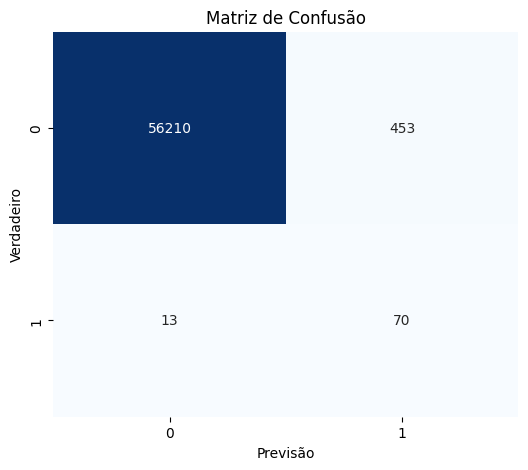

In [29]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

## Regressão Logística com pesos ajustados

In [30]:
log_reg_w = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [31]:
log_reg_w.fit(X_train, y_train)

/Users/nicole.petrica/Workspace/Studies/credit-card-fraud/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [32]:
y_pred_w = log_reg_w.predict(X_test)

In [33]:
results_weights = {
    "Modelo": "Pesos Ajustados",
    "ROC-AUC": roc_auc_score(y_test, log_reg_w.predict_proba(X_test)[:,1]),
    "PR-AUC": average_precision_score(y_test, log_reg_w.predict_proba(X_test)[:,1]),
    "Precision": classification_report(y_test, y_pred_w, output_dict=True)["1"]["precision"],
    "Recall": classification_report(y_test, y_pred_w, output_dict=True)["1"]["recall"],
    "F1": classification_report(y_test, y_pred_w, output_dict=True)["1"]["f1-score"],
}

In [34]:
cm_w = confusion_matrix(y_test, y_pred_sm)

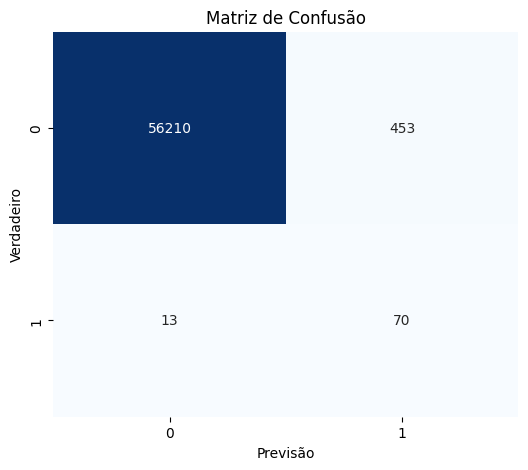

In [35]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

## Comparação entre os modelos

In [36]:
df_results = pd.DataFrame([results_normal, results_smote, results_weights])

In [37]:
df_results

,Modelo,ROC-AUC,PR-AUC,Precision,Recall,F1
0,Normal,0.577625,0.003007,0.034483,0.012048,0.017857
1,SMOTE,0.975091,0.690135,0.133843,0.843373,0.231023
2,Pesos Ajustados,0.972815,0.691963,0.048431,0.855422,0.091672
